<a href="https://colab.research.google.com/github/hoihui/pkgs/blob/master/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !pip3 install -U torch torchvision
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Sine Curve

## Torch

In [0]:
import torch
cuda=torch.cuda.is_available()
torch.__version__, cuda

('1.1.0', True)

https://github.com/udacity/deep-learning-v2-pytorch/blob/master/recurrent-neural-networks/time-series/Simple_RNN.ipynb

### Generate Data

In [0]:
time_steps = np.linspace(0, np.pi, 21)
data = np.sin(time_steps).reshape((21,1))  #last dim of 1 is the number of features at each time instance (just a number here)
inp, tar = data[:-1], data[1:]

# illustration
plt.plot(time_steps[1:], inp, 'r.', label='input, x')
plt.plot(time_steps[1:], tar, 'b.', label='target, y')

### Constructing 1-layer Model

Recall: RNN unit:
* input: previous hidden state (could have layers) and current input
* output: next hidden state (could have layers) and current output features (to be fed to a dense layer to generate final output)

https://pytorch.org/docs/stable/nn.html#rnn
* **input_size** - # features at each time instance (=1, a number)
* **output_size** - # output dim at each time instance (=1, a number)
* **hidden_dim** - # dimension in the hidden state
* **n_layers** - # layers making up the RNN, typically 1-3; > 1 means stacked RNN
* **batch_first** - whether batch_size as the first dimension `(batch_size, seq_length, hidden_dim)`

**nn.RNN is not a single-time instance**.  Fed in full sequence `(batch_size, seq_length, input_size)` with hidden states `(n_layers,batch_size,hidden_dim)`, outputs `(batch_size, seq_length, hidden_dim)` and next hidden state `(n_layers,batch_size,hidden_dim)`

In [0]:
from torch import nn
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        
        self.hidden_dim=hidden_dim
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        # in.shape =(batch_size, seq_length, input_size),(n_layers,batch_size,hidden_dim)
        # out.shape=(batch_size, seq_length, hidden_dim),(n_layers,batch_size,hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_size)  # in (batch_size*seq_length, hidden_dim), out (batch_size*seq_length, 1)

    def forward(self, x, hidden):   # x.shape = (batch_size, seq_length, input_size)
                                    # hidden.shape = (n_layers, batch_size, hidden_dim)
                                    # r_out.shape = (batch_size, time_step, hidden_size)
        batch_size = x.size(0)
        
        r_out, hidden = self.rnn(x, hidden)
        r_out = r_out.view(-1, self.hidden_dim)   # reshape to pass to fc layer
        
        output = self.fc(r_out)     # out (batch_size*seq_length, 1)
        
        return output, hidden

In [0]:
# dimensions test
rnn = RNN(input_size=1, output_size=1, hidden_dim=12, n_layers=2)

test_input = torch.rand((1,22,1)) # batch_size of 1 as first dimension, feature dim of 1 as last dimension
print('Input size: ', test_input.shape)

pred, hidden = rnn(x=test_input, hidden=torch.rand((2,1,12)))
print('Output size: ', pred.shape)
print('Hidden state size: ', hidden.shape)

Input size:  torch.Size([1, 22, 1])
Output size:  torch.Size([22, 1])
Hidden state size:  torch.Size([2, 1, 12])


### Train

In [0]:
seq_length=20
input_size=1 
output_size=1
hidden_dim=32
n_layers=1
n_steps = 90
print_every = 30

rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


Loss:  0.0034269089810550213


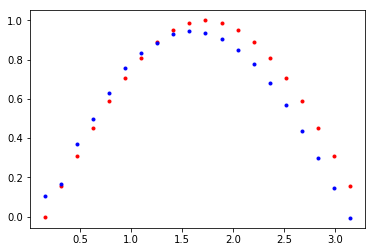

Loss:  4.2462361307116225e-05


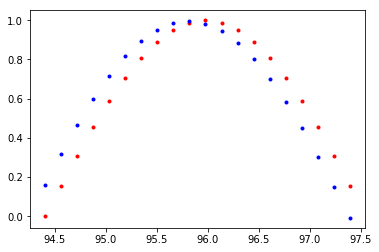

Loss:  3.917669459951867e-07


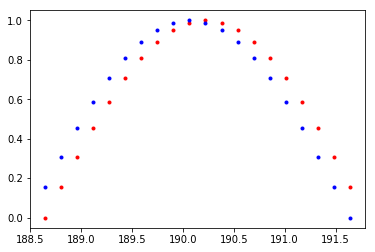

In [0]:
hidden = None
for step in range(n_steps):
    # training data = sine curve (continues from previous)
    time_steps = np.linspace(step*np.pi, (step+1)*np.pi, seq_length + 1)
    data = np.sin(time_steps)
    X = torch.Tensor(data[:-1]).view(1,seq_length,1) # gives batch_size dim of 1
    y = torch.Tensor(data[1:]).view(seq_length,1)
    
    prediction, hidden = rnn(X, hidden) # forward
    hidden = hidden.detach()            # don't backpropagate through the entire history

    loss = criterion(prediction, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step%print_every == 0:        
        print('Loss: ', loss.item())
        plt.plot(time_steps[1:], X.numpy().flatten(), 'r.') # input
        plt.plot(time_steps[1:], prediction.detach().numpy().flatten(), 'b.') # predictions
        plt.show()

### Generate

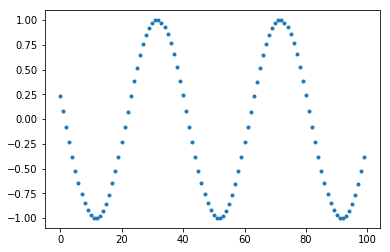

In [0]:
y=[]
for _ in range(100):
    with torch.no_grad():
        y+=X.numpy().flatten()[-1],
        X=torch.Tensor([y[-1]]).view(1,1,1)  # batchsize, seqlen, feature dim
        X, hidden = rnn(X, hidden)
plt.plot(range(len(y)),y,'.')

# char-rnn

## Torch

https://github.com/udacity/deep-learning-v2-pytorch/blob/master/recurrent-neural-networks/char-rnn/Character_Level_RNN_Solution.ipynb

https://classroom.udacity.com/courses/ud188/lessons/a8fc0724-37ed-40d9-a226-57175b8bb8cc/concepts/6538eb14-1ec2-4a25-bc73-5942a48b1141

In [0]:
import torch
cuda=torch.cuda.is_available()
torch.__version__, cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
seqlen = 20

### Data

In [0]:
import os,urllib,tempfile
os.chdir(tempfile.gettempdir())
url='https://github.com/udacity/deep-learning-v2-pytorch/raw/master/recurrent-neural-networks/char-rnn/data/anna.txt'
urllib.request.urlretrieve(url,'anna.txt')
with open('anna.txt', 'r') as f:
    text = f.read()
text[:15]

'Chapter 1\n\n\nHap'

#### Preprocess

In [0]:
# Construct int mapping; will be built into Network Module
chars=set(text)
int2char = dict(enumerate(chars))
char2int = {v: k for k,v in int2char.items()}
encoded = np.array([char2int[ch] for ch in text])
nchars = len(set(int2char))
encoded[:15]

array([81, 66, 17,  1, 64, 33, 13, 25, 48, 73, 73, 73,  9, 17,  1])

<img src="https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/recurrent-neural-networks/char-rnn/assets/sequence_batching.png">

In [0]:
# batch loader: in (N,); out generates (batch_size, seqlen)x2   ##NON-OVERLAPPING
def Batch_Loader(arr, batch_size, seqlen):    
    batch_size_total = batch_size * seqlen
    n_batches = len(arr)//batch_size_total     # number of batches
    X_size_total = n_batches * batch_size_total
    
    if len(arr) > X_size_total:                # special treatment for the last batch's target so it doesn't wrap around; not important
        arr_ = arr[:X_size_total].reshape((batch_size, -1))
        arr  = np.hstack((arr_,np.vstack((arr_[1:,:1],[arr[X_size_total]]))))
    else:
        arr = arr[:X_size_total].reshape((batch_size, -1))
    
    for n in range(0, arr.shape[1], seqlen):
        x = arr[:, n:n+seqlen]
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+seqlen]
        except IndexError:
            break
#             y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield x, y
for x,y in Batch_Loader(np.array(range(31)),3,5):
    print('x:',x)
    print('y:',y)

x: [[ 0  1  2  3  4]
 [10 11 12 13 14]
 [20 21 22 23 24]]
y: [[ 1  2  3  4  5]
 [11 12 13 14 15]
 [21 22 23 24 25]]
x: [[ 5  6  7  8  9]
 [15 16 17 18 19]
 [25 26 27 28 29]]
y: [[ 6  7  8  9 10]
 [16 17 18 19 20]
 [26 27 28 29 30]]


In [0]:
# One-Hot Encoding: in (batch_size, seqlen); out (batch_size, seqlen, nchars)
def One_Hot_Encode(arr, nchars=nchars):
    one_hot = np.zeros((arr.size, nchars), dtype=np.float32)
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    one_hot = one_hot.reshape((*arr.shape, nchars))
    return one_hot
One_Hot_Encode(np.array([[3,5,1],[4,2,7]]), 8)

array([[[0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.]]], dtype=float32)

### Model

<img src="https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/recurrent-neural-networks/char-rnn/assets/charRNN%400.5x.png">

`nn.LSTM(input_size, n_hidden, n_layers, dropout=drop_prob, batch_first=True)`:
* input_size: number of characters as sequential input,
* n_hidden: number of units in the hidden layers
* n_layers: Number of LSTM units in each time instance
* dropout: dropout to the inputs or outputs and in-between the layers

In [0]:
from torch import nn
class CharRNN(nn.Module):    
    def __init__(self, tokens, n_hidden=512, n_layers=2, drop_prob=0.5):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        
        # int mappings
        self.chars = tokens
        self.int2char = dict(enumerate(self.chars))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}
        
        # net structure
        self.lstm = nn.LSTM(len(self.chars), n_hidden, n_layers,    
                            dropout=drop_prob, batch_first=True)   # in: (batch_size, seqlen, nchars), out: (batch_size,seqlen,n_hidden), hidden
        self.dropout = nn.Dropout(drop_prob)        
        self.fc = nn.Linear(n_hidden, len(self.chars))
      
    
    def forward(self, x, hidden):
        r_output, hidden = self.lstm(x, hidden)
        out = self.dropout(r_output)
        
        out = out.contiguous().view(-1, self.n_hidden) # contiguous: makes a copy of tensor so the order of elements would be same as if tensor of same shape created from scratch
        out = self.fc(out)
        
        return out, hidden
    
    
    def init_hidden(self, batch_size):  # produce hidden & cell state conforming with the LSTM (n_layers , batch_size , n_hidden), 
        weight = next(self.parameters()).data   #get the LSTM parameters (for its datatype)
        hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device))        
        return hidden

In [0]:
net = CharRNN(chars)
print(net)
opt = torch.optim.Adam(net.parameters(), lr=.001)
criterion = nn.CrossEntropyLoss()

CharRNN(
  (lstm): LSTM(83, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5)
  (fc): Linear(in_features=512, out_features=83, bias=True)
)


### Train

In [0]:
batch_size = 128
seqlen = 100
epochs = 20
clip=5          #max gradient allowed
val_frac=0.1

* use `clip_grad_norm_` to help prevent exploding gradients
* detach hidden state to not backprop the entire history

In [0]:
if cuda: net.cuda()

# create train/val; each of them must be contiguous
val_idx = int(len(encoded)*(1-val_frac))
train, val = encoded[:val_idx], encoded[val_idx:]

for e in range(epochs):
    h = net.init_hidden(batch_size)    # initialize hidden state
    
    for i, (x, y) in enumerate(Batch_Loader(train, batch_size, seqlen)):
        net.train()

        # prepare training sample: 1Hot, to torch, to cuda
        x = One_Hot_Encode(x)
        x, y = torch.from_numpy(x), torch.from_numpy(y)
        if cuda: x, y = x.cuda(), y.cuda()

        h = tuple([e.data for e in h]) #detach (to not backprop history)

        net.zero_grad()
        output, h = net(x, h)
        loss = criterion(output, y.view(y.numel()).long())
        loss.backward()        
        nn.utils.clip_grad_norm_(net.parameters(), clip)# prevent exploding gradient
        opt.step()

        if i % 50 == 0:      #validation stats
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for x, y in Batch_Loader(val, batch_size, seqlen):
                x = One_Hot_Encode(x)
                x, y = torch.from_numpy(x), torch.from_numpy(y)
                if cuda: x, y = x.cuda(), y.cuda()

                val_h = tuple([e.data for e in val_h])

                output, val_h = net(x, val_h)
                val_loss = criterion(output, y.view(y.numel()).long())
                val_losses += val_loss.item(),

            print(f"\rEpoch {e}",
                  f"Step {i}:",
                  f"Loss: {loss.item():.4f},",
                  f"Val Loss: {np.mean(val_losses):.4f}",end='')

Epoch 19 Step 100: Loss: 1.1761, Val Loss: 1.2611

### Prediction / Text generation

In [0]:
import torch.nn.functional as F

def predict(net, char, h):   # model, 1 char, hidden_state        
    x = np.array([[net.char2int[char]]])
    x = One_Hot_Encode(x)
    x = torch.from_numpy(x)        
    if cuda: x = x.cuda()

    h = [e.data for e in h]
    out, h = net(x, h)

    p = F.softmax(out, dim=1).data    # probabilities
    if cuda: p = p.cpu()

    p = p.numpy().squeeze()  
    char = np.random.choice(range(nchars), p=p/p.sum()) # select char according to p

    return net.int2char[char], h

In [0]:
start = 'Human'
size = 2000

if cuda: net.cuda()
else:    net.cpu()
net.eval()

s = start

h = net.init_hidden(batch_size=1)
for ch in start:       # feed the first word through without making predictions
    char, h = predict(net, ch, h)
s+=char

for ii in range(size):
    char, h = predict(net, s[-1], h)
    s+=char

print(s)

Humants
kiffered by his. She arranged this affairs to him. She had the commission might
gave love.

"Birch persapt is it?" said Kitty, giving incaparitial catching his
figure; in the great beginning to was the modest papes had never
meet harrly dainer. He knew hes something with it was so could have not to
go up, and was like thaising that seemed to the members of the
morning sent to understand that he had come at done to watch to its brown back
from his place.

"Who's I see that yesterday. Ah, with Ged at miserable sweep..."

"She gares her the prica. That's not to think you it's to do," said he was
looking with out of the troussea,
of the table, his forehead, in a tiely tried to profly chain. The
family other bard a moment failing to Darya Alexandrovna's hand on whom Levin
began to grand the buckingrees heart, that not in these relations
birachess.

"If I tell you--that's the reely."

"That's my hinllow business and your childness that is calagient for it.
But "Capitale, now di nothi

## Keras

* https://github.com/mineshmathew/char_rnn_karpathy_keras
* https://www.tensorflow.org/alpha/tutorials/text/text_generation

In [4]:
# !pip install -q tensorflow-gpu==2.0.0-alpha0
import numpy as np
import tensorflow as tf
from tensorflow import keras
tf.__version__, keras.__version__

('2.0.0-alpha0', '2.2.4-tf')

### Data

In [23]:
import os, tempfile
os.chdir(tempfile.gettempdir())
# path = tf.keras.utils.get_file('nietzsche.txt', origin="https://s3.amazonaws.com/text-datasets/nietzsche.txt")
path = tf.keras.utils.get_file('shakespeare.txt', origin="https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt")
text = open(path).read().lower()
print (f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [30]:
vocab = sorted(list(set(text)))
print('total chars:', len(vocab))
char2int = dict((c, i) for i, c in enumerate(vocab))
int2char = np.array(vocab)  #dict((i, c) for i, c in enumerate(vocab))

total chars: 39


#### Building training set

In [12]:
# (1) explicitly build batches [a,b,c,d] --> [b,c,d], [b,c,d]--->[c,d,e]....and so on
seqlen, step = 40, 1
sentences = []
next_chars = []
for i in range(0, len(text) - seqlen+1, step):
    sentences.append(text[i: i + seqlen])
    next_chars.append(text[i+1:i +1+ seqlen])
print('number of sequences:', len(sentences))

import numpy as np
X = np.zeros((len(sentences),seqlen,len(vocab)),dtype=np.bool)#dataSize x seqLength x vocabSize
y = np.zeros((len(sentences),seqlen,len(vocab)),dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char2int[char]] = 1

for i, sentence in enumerate(next_chars):
    for t, char in enumerate(sentence):
        y[i, t, char2int[char]] = 1

total chars: 57
number of sequences: 600854


In [46]:
# (2) generator
seqlen = 100
examples_per_epoch = len(text)//seqlen
text_as_int = [char2int[c] for c in text]

char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)  # individual chars
for i in char_dataset.take(25):
  print(int2char[i.numpy()],end='')

sequences = char_dataset.batch(seqlen+1, drop_remainder=True) # sequences
for seq in sequences.take(5):
  print(repr(''.join(int2char[seq.numpy()])))
  
Xy = sequences.map(lambda chunk:(chunk[:-1],chunk[1:]) )  # X,y (both are sequences)
for X, y in  Xy.take(2):   # not shifted by step=1
  print('X: ', repr(''.join(int2char[X.numpy()])) )
  print('y: ', repr(''.join(int2char[y.numpy()])) )
  
Xy = Xy.shuffle(buffer_size=10000).batch(batch_size=64, drop_remainder=True) #shuffle and batch
Xy

first citizen:
before we 'first citizen:\nbefore we proceed any further, hear me speak.\n\nall:\nspeak, speak.\n\nfirst citizen:\nyou '
'are all resolved rather to die than to famish?\n\nall:\nresolved. resolved.\n\nfirst citizen:\nfirst, you k'
"now caius marcius is chief enemy to the people.\n\nall:\nwe know't, we know't.\n\nfirst citizen:\nlet us ki"
"ll him, and we'll have corn at our own price.\nis't a verdict?\n\nall:\nno more talking on't; let it be d"
'one: away, away!\n\nsecond citizen:\none word, good citizens.\n\nfirst citizen:\nwe are accounted poor citi'
X:  'first citizen:\nbefore we proceed any further, hear me speak.\n\nall:\nspeak, speak.\n\nfirst citizen:\nyou'
y:  'irst citizen:\nbefore we proceed any further, hear me speak.\n\nall:\nspeak, speak.\n\nfirst citizen:\nyou '
X:  'are all resolved rather to die than to famish?\n\nall:\nresolved. resolved.\n\nfirst citizen:\nfirst, you '
y:  're all resolved rather to die than to famish?\n\nall:\nresolved. resolved.\n\nfi

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int32, tf.int32)>

### Model

In [7]:
# (1) no embedding; LSTM is NOT stateful (training corpus have huge repetitions with step=1)
hiddenSizes = [512,512]
dropoutProb = 0.2

model = keras.models.Sequential([
    keras.layers.LSTM(hiddenSizes[0], return_sequences=True, input_shape=(seqlen, len(vocab))),
    keras.layers.LSTM(hiddenSizes[1], return_sequences=True),
    keras.layers.Dropout(dropoutProb),
    keras.layers.TimeDistributed(keras.layers.Dense(len(vocab),activation='softmax')),
])

model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
model.summary()

W0526 22:51:18.541334 140072895281024 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f64c0207860>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0526 22:51:18.545431 140072895281024 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f64c0207dd8>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unified_lstm_2 (UnifiedLSTM) (None, 40, 512)           1167360   
_________________________________________________________________
unified_lstm_3 (UnifiedLSTM) (None, 40, 512)           2099200   
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 512)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 40, 57)            29241     
Total params: 3,295,801
Trainable params: 3,295,801
Non-trainable params: 0
_________________________________________________________________


In [47]:
# (2) with embedding; LSTM is stateful, requires batchsize input. corpus has no repetition
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024
batch_size = 64

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),  #batchsize input
    tf.keras.layers.LSTM(rnn_units,
                         return_sequences=True,
                         stateful=True,
                         recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size, activation='softmax')
  ])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.summary()

W0526 23:43:51.554454 140072895281024 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f641e795e48>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (64, None, 256)           9984      
_________________________________________________________________
unified_lstm_8 (UnifiedLSTM) (64, None, 1024)          5246976   
_________________________________________________________________
dense_6 (Dense)              (64, None, 39)            39975     
Total params: 5,296,935
Trainable params: 5,296,935
Non-trainable params: 0
_________________________________________________________________


### Train

In [9]:
# (1)
history=model.fit(X, y, batch_size=128, epochs=3,verbose=1)
print ('loss is',history.history['loss'][0])

Epoch 1/3
600854/600854 [==============================] - 189s 315us/sample - loss: 1.1020
Epoch 2/3
600854/600854 [==============================] - 189s 315us/sample - loss: 0.6808
Epoch 3/3
600854/600854 [==============================] - 190s 316us/sample - loss: 0.5654
loss is 1.1020105174576489


In [48]:
# (2)
history = model.fit(Xy, epochs=3)

Epoch 1/3
172/172 [==============================] - 16s 93ms/step - loss: 2.4768
Epoch 2/3
172/172 [==============================] - 15s 88ms/step - loss: 1.8201
Epoch 3/3
172/172 [==============================] - 14s 82ms/step - loss: 1.5714


### Generate

In [0]:
# (1)
seed="brutus: this aint right. you should be going"
print(seed,end='')
for i in range(1000):
    x=np.zeros((1, seqlen, len(vocab)))
    for t, char in enumerate(seed[-seqlen:]):
        x[0, t, char2int[char]] = 1.
    preds = model.predict(x, verbose=0)[0]
    next_index = np.random.choice(range(len(vocab)),p=preds[-1])  #np.argmax(preds[-1])
    next_char = int2char[next_index]
    seed = seed + next_char
    print(next_char,end='')

In [51]:
# (2)
seed="brutus: this aint right. you should be going"
print(seed,end='')
# model.reset_states()
# model.build(tf.TensorShape([1, None]))  # reset batchsize=1 here

x = [char2int[s] for s in seed]
x = tf.expand_dims(x, 0)
model(x)
# for i in range(100):
#     predictions = model(input_eval)
#     predictions = tf.squeeze(predictions, 0)

#     predictions = predictions / temperature
#     predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

#     # along with the previous hidden state
#     input_eval = tf.expand_dims([predicted_id], 0)

#     text_generated.append(idx2char[predicted_id])


brutus: this aint right. you should be going

InvalidArgumentError: ignored

# IMDB Sentiment by RNN with LSTM

https://github.com/udacity/deep-learning-v2-pytorch/blob/master/sentiment-rnn/Sentiment_RNN_Solution.ipynb

In [0]:
# !pip3 install -U torch torchvision
import torch
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.__version__, cuda

('1.1.0', False)

## Data

In [0]:
# import os,urllib,tempfile
# os.chdir(tempfile.gettempdir())
# urllib.request.urlretrieve('https://github.com/udacity/deep-learning-v2-pytorch/raw/master/sentiment-rnn/data/reviews.txt','reviews.txt')
# urllib.request.urlretrieve('https://github.com/udacity/deep-learning-v2-pytorch/raw/master/sentiment-rnn/data/labels.txt','labels.txt')
with open('reviews.txt', 'r') as f: reviews = f.read().strip()
with open('labels.txt', 'r') as f:  labels = f.read().strip()
print(reviews[:1000])
print(labels[:20])

bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life  such as  teachers  . my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers  . the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students . when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled . . . . . . . . . at . . . . . . . . . . high . a classic line inspector i  m here to sack one of your teachers . student welcome to bromwell high . i expect that many adults of my age think that bromwell high is far fetched . what a pity that it isn  t   
story of a man who has unnatural feelings for a pig . starts out with a opening scene that is a terrific example of absurd comedy . a formal orchestra audience is turn

### Preprocess

In [0]:
# encode labels
labels = np.array([int(l[0]=='p') for l in labels.split('\n')]) #now list of int

In [0]:
# tokenize
from string import punctuation
reviews = ''.join(c for c in reviews if c not in punctuation)
reviews = reviews.lower().split('\n')  #now list of strings

words = [w for sent in reviews for w in sent.split()]
Nw = len(words)

In [0]:
# encode reviews
from collections import Counter

counts = Counter(words)
vocab = sorted(counts, key=counts.get, reverse=True)
vocab2int = {word: ii+1 for ii, word in enumerate(vocab)}
Nv = len(vocab2int)

reviews = [[vocab2int[word] for word in r.split()] for r in reviews]  #now list of list of int

In [0]:
# pad/truncate reviews to constant length
seqlen =  200
reviews = np.asarray([([0]*(seqlen-len(r))+r)[:200] for r in reviews])

### train/val/test

In [0]:
train_frac = 0.8
val_frac = 0.1

val_start  = int(len(reviews)*train_frac)
test_start = val_start + int(len(reviews)*val_frac)
train_x, val_x, test_x = reviews[:val_start], reviews[val_start:test_start], reviews[test_start:]
train_y, val_y, test_y = labels[:val_start],  labels[val_start:test_start],  labels[test_start:]

print("Feature Shapes:\n",
      train_x.shape, 
      val_x.shape,
      test_x.shape)

Feature Shapes:
 (20000, 200) (2500, 200) (2500, 200)


### Batch Loader

In [0]:
import torch
from torch.utils.data import TensorDataset, DataLoader

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

batch_size = 50

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [0]:
sample_x, sample_y = next(iter(train_loader))

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([50, 200])
Sample input: 
 tensor([[   40,    26,   106,  ...,   674,   332,    32],
        [    8,   552,    71,  ...,    42,    24,   142],
        [   10,   139,   329,  ...,  2771,  5770,   282],
        ...,
        [   10,    14,  9088,  ...,    64,  2443,     4],
        [    0,     0,     0,  ...,     7,     7, 54291],
        [    0,     0,     0,  ...,     5,    75,     8]])

Sample label size:  torch.Size([50])
Sample label: 
 tensor([1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
        0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
        0, 1])


## Model

<img src="https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/sentiment-rnn/assets/network_diagram.png" width="200px"/>

In [0]:
lr=0.001
epochs = 4 # 3-4 is approx where I noticed the validation loss stop decreasing
print_every = 100
clip=5 # gradient clipping

In [0]:
import torch.nn as nn

class SentimentRNN(nn.Module):

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(SentimentRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)        
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        out = self.dropout(lstm_out)
        out = self.fc(out)
        sig_out = self.sig(out)
        
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1]
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        # Helper init hidden & cell states of size (n_layers, batch_size, hidden_dim)
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        
        return hidden
    
vocab_size = Nv + 1 # for 0 padding
output_size = 1
embedding_dim = 400
hidden_dim = 256
n_layers = 2
net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
print(net)

SentimentRNN(
  (embedding): Embedding(74073, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [0]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

## Train

In [0]:
if cuda: net.cuda()
net.train()
for e in range(epochs):
    h = net.init_hidden(batch_size)
    for i, (inputs, labels) in enumerate(train_loader):

        if cuda: inputs, labels = inputs.cuda(), labels.cuda()
        h = tuple([each.data for each in h])  # so as not to backprop to past

        net.zero_grad()
        output, h = net(inputs, h)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        if i % print_every == 0:
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:
                if cuda: inputs, labels = inputs.cuda(), labels.cuda()
                val_h = tuple([each.data for each in val_h]) # so as not to backprop to past

                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())
                val_losses.append(val_loss.item())

            net.train()
            print(f"Epoch: {e+1}/{epochs}...",
                  f"Step: {counter}...",
                  f"Loss: {loss.item():.6f}...",
                  f"Val Loss: {np.mean(val_losses):.6f}")

## Evaluate

### on test set

In [0]:
test_losses = [] # track loss
num_correct = 0

h = net.init_hidden(batch_size)
net.eval()
for inputs, labels in test_loader:
    h = tuple([each.data for each in h])

    if cuda:   inputs, labels = inputs.cuda(), labels.cuda()
    
    output, h = net(inputs, h)
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    pred = torch.round(output.squeeze())   # to either 0 or 1
    
    correct_tensor = pred.eq(labels.float().view_as(pred))
    if cuda: correct_tensor=correct_tensor.cpu()
    correct = np.squeeze(correct_tensor.numpy())
    num_correct += np.sum(correct)


print(f"Test loss: {np.mean(test_losses):.3f}")
print(f"Test accuracy: {num_correct/len(test_loader.dataset):.3f}")

### on new data

# IMDB large sentiment by Bidirectional LSTM

https://www.tensorflow.org/alpha/tutorials/text/text_classification_rnn

In [0]:
!pip install -q tensorflow-gpu==2.0.0-alpha0
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras

## Load Data

In [0]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [0]:
tokenizer = info.features['text'].encoder
print(tokenizer.encode('sample string'))
print(tokenizer.decode(tokenizer.encode('sample string')))

[460, 4568, 49, 5875]
sample string


In [0]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, train_dataset.output_shapes)
test_dataset = test_dataset.padded_batch(BATCH_SIZE, test_dataset.output_shapes)

## Model

In [0]:
embed_dim=64
model = keras.Sequential([
    keras.layers.Embedding(tokenizer.vocab_size, embed_dim),
    keras.layers.Bidirectional(tf.keras.layers.LSTM(embed_dim)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

W0525 13:38:09.723803 140406638167936 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7fb2704078d0>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0525 13:38:09.729490 140406638167936 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7fb270310978>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


In [0]:
# 2 layers
embed_dim=64
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embed_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embed_dim, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),  #???
    tf.keras.layers.Dense(embed_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Train

In [0]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 73s 187ms/step - loss: 0.5591 - accuracy: 0.7080 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
391/391 [==============================] - 68s 173ms/step - loss: 0.4943 - accuracy: 0.7756 - val_loss: 0.5828 - val_accuracy: 0.7039
Epoch 3/10
391/391 [==============================] - 68s 173ms/step - loss: 0.4360 - accuracy: 0.8133 - val_loss: 0.4864 - val_accuracy: 0.7809
Epoch 4/10
391/391 [==============================] - 67s 172ms/step - loss: 0.3825 - accuracy: 0.8386 - val_loss: 0.4843 - val_accuracy: 0.8057
Epoch 5/10
391/391 [==============================] - 67s 172ms/step - loss: 0.2997 - accuracy: 0.8796 - val_loss: 0.4464 - val_accuracy: 0.7953
Epoch 6/10
391/391 [==============================] - 68s 174ms/step - loss: 0.2444 - accuracy: 0.9071 - val_loss: 0.4224 - val_accuracy: 0.8240
Epoch 7/10
391/391 [==============================] - 67s 172ms/step - loss: 0.2104 - accuracy: 0.9230 - val_loss: 0.4450 

## Evaluate

In [0]:
test_loss, test_acc = model.evaluate(test_dataset)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

    391/Unknown - 23s 58ms/step - loss: 0.5491 - accuracy: 0.8158Test Loss: 0.5490736904199166
Test Accuracy: 0.8158000111579895


In [0]:
# New data
s = "I used to hate his move. This is out of expectation"
tokenized = tokenizer.encode(s)
model.predict(tf.expand_dims(tokenized,0))

array([[0.3861948]], dtype=float32)

# [HRNN](https://github.com/fchollet/keras/blob/master/examples/mnist_hierarchical_rnn.py)

In [0]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, TimeDistributed
from keras.layers import LSTM
batch_size = 32
nb_epochs = 5
row_hidden = 128
col_hidden = 128

## Data

In [0]:
X_train_ = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test_ = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
row, col, pixel = X_train_.shape[1:]

## Model

In [0]:
x = Input(shape=(row, col, pixel))
encoded_rows = TimeDistributed(LSTM(output_dim=row_hidden))(x)
encoded_columns = LSTM(col_hidden)(encoded_rows)
prediction = Dense(10, activation='softmax')(encoded_columns)
model = Model(input=x, output=prediction)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
model.summary()

In [0]:
model.fit(X_train_, Y_train, batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_test_, Y_test))

scores = model.evaluate(X_test_, Y_test, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])